In [1]:
import numpy as np
import pandas as pd
import os
import glob

In [3]:
DATA_PATH    = 'Documents/GitHub/labs/fin-ops/downloader-data'
TICKERS_PATH = 'Documents/GitHub/labs/fin-ops/tickers'

## 1 - data collection

### read tickers

In [4]:
ticker_files = glob.glob(f'{TICKERS_PATH}/*')
ticker_dfs = []
for tf in ticker_files[1:]:
    ticker_dfs.append(pd.read_csv(tf))

tickers = pd.concat(ticker_dfs, ignore_index=True)


### read data

In [5]:
data_for_ticker = {}
for index, (ticker, name) in tickers.iterrows():
    try:
        df = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
        if len(df) > 100:
            data_for_ticker[ticker] = df
    except:
        pass
    
print(data_for_ticker['AAPL'])

           Date       Close     Volume
0    2020-10-27  116.599998   92276800
1    2020-10-28  111.199997  143937800
2    2020-10-29  115.320000  146129200
3    2020-10-30  108.860001  190272600
4    2020-11-02  108.769997  122866900
..          ...         ...        ...
248  2021-10-21  149.479996   61421000
249  2021-10-22  148.690002   58839600
250  2021-10-25  148.639999   50720600
251  2021-10-26  149.320007   60893400
252  2021-10-27  148.850006   55951800

[253 rows x 3 columns]


## 2 - assets map

### compute log return

In [6]:
for ticker, data in data_for_ticker.items():
    data_for_ticker[ticker] = data.assign(logret=np.log(data.Close).diff())
    data_for_ticker[ticker]['minus_logret'] = data_for_ticker[ticker]['logret'].mul(-1)

In [7]:
data_for_ticker['AAPL']

,Date,Close,Volume,logret,minus_logret
0,2020-10-27,116.599998,92276800,NaN,NaN
1,2020-10-28,111.199997,143937800,-0.047419,0.047419
2,2020-10-29,115.320000,146129200,0.036381,-0.036381
3,2020-10-30,108.860001,190272600,-0.057648,0.057648
4,2020-11-02,108.769997,122866900,-0.000827,0.000827
...,...,...,...,...,...
248,2021-10-21,149.479996,61421000,0.001473,-0.001473
249,2021-10-22,148.690002,58839600,-0.005299,0.005299
250,2021-10-25,148.639999,50720600,-0.000336,0.000336
251,2021-10-26,149.320007,60893400,0.004564,-0.004564


### compute logret_mean, logret_std

In [8]:
estims = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
estims.set_index('ticker', inplace=True)

for ticker, data in data_for_ticker.items():
    estims.loc[ticker] = [data['logret'].mean(), data['logret'].std()]
    
estims

,logret_mean,logret_std
ticker,,
YNDX,0.001073,0.019525
ROSN,0.005203,0.124752
ALRS,0.001398,0.025130
MGNT,-0.027981,0.522049
POLY,0.001039,0.042375
...,...,...
CONTROLPR,-0.001061,0.026090
CORALFINAC,-0.001317,0.034008
CORDSCABLE,-0.001831,0.024574


### plot the map

In [87]:
import plotly.express as px
from sklearn.preprocessing import normalize

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig.show()

In [93]:
ticker_colour.sort_values(ascending=False)
print (ticker_colour.sort_values(ascending=False)[:20])

ticker
PRFT     0.242755
ANAT     0.208966
III      0.201769
WIRE     0.192437
OFS      0.189921
DXLG     0.189558
PMBC     0.188537
FTNT     0.185266
CG       0.182700
GAIN     0.178581
SBNY     0.175160
TGA      0.170571
TRNS     0.169724
AAVAS    0.168470
PDBC     0.168069
JYNT     0.163915
CRAI     0.161748
CSWC     0.161243
ARLP     0.160224
UHAL     0.160175
dtype: float64


## 3 - uniform portfolio

In [10]:
import plotly.graph_objects as go

# TODO: check
uniform_logret_mean = estims['logret_mean'].mean()
uniform_logret_std = estims['logret_std'].mean()

print(f'UNIFORM std:{uniform_logret_std}, mean:{uniform_logret_mean}')

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)
fig.show()

UNIFORM std:0.035793795775315884, mean:0.0007932805203758912


## 5 - VaR

In [11]:
def getVaR(data, tLVL):
    if isinstance(data, pd.DataFrame):
        return data.aggregate(getVaR, tLVL=tLVL)
    elif isinstance(data, pd.Series):
        return -np.percentile(data, tLVL)
    else:
        raise TypeError("Expected data to be a Series or DataFrame")

In [12]:
TRUST_LEVELS = [90, 95, 97.5]

tickersVaRs = pd.DataFrame(data=[], columns=['ticker'] + [f'VaR-{tLVL}' for tLVL in TRUST_LEVELS])

# compute VaR to tickers     
for index, (ticker, data) in enumerate(data_for_ticker.items()):
    tickersVaRs_row = [ticker]
    for tLVL in TRUST_LEVELS:
        quantile_value = getVaR(data['minus_logret'][1:], tLVL)
        tickersVaRs_row.append(quantile_value)
    tickersVaRs.loc[index] = tickersVaRs_row
            
# plot values     
tickersVaRs

,ticker,VaR-90,VaR-95,VaR-97.5
0,YNDX,-0.023284,-0.032719,-0.036929
1,ROSN,-0.097256,-0.156295,-0.268276
2,ALRS,-0.029227,-0.039852,-0.046043
3,MGNT,-0.499947,-0.910492,-1.064942
4,POLY,-0.047761,-0.058601,-0.076483
...,...,...,...,...
1948,CONTROLPR,-0.031692,-0.036013,-0.040982
1949,CORALFINAC,-0.037655,-0.050258,-0.061254
1950,CORDSCABLE,-0.030867,-0.038608,-0.045046
1951,COROMANDEL,-0.015086,-0.023460,-0.027375


In [13]:
import plotly.express as px

for tLVL in TRUST_LEVELS:
    VaR_column = f'VaR-{tLVL}'
    tickersVaRs = tickersVaRs.sort_values(by=VaR_column, ascending=False)
    
    tLVL_fig = px.bar(tickersVaRs, x='ticker', y=VaR_column,
                 color=f'{VaR_column}', color_continuous_scale=px.colors.diverging.RdYlGn,
                 height=400)
    tLVL_fig.show()

In [14]:
tickersVaRs = tickersVaRs.sort_values(by='VaR-95', ascending=False)
best_VaR_ticker = tickersVaRs['ticker'].iloc[0]
best_VaR_mean = estims.loc[best_VaR_ticker]['logret_mean']
best_VaR_std = estims.loc[best_VaR_ticker]['logret_std']

print(f'Best Var Ticker - {best_VaR_ticker}, std:{best_VaR_std}, mean:{best_VaR_mean}')

fig.add_scatter(x=[best_VaR_std], y=[best_VaR_mean], mode="markers",
                marker=dict(size=20, color="Brown"), text=['Best VaR'], name='Best VaR')

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)


Best Var Ticker - FTSM, std:0.0001625604511668486, mean:-1.1906775149388039e-05


## 6 - White Noise Check

### select tickers

In [15]:
tickers = tickersVaRs['ticker'].iloc[:4].values
for ticker in tickers:
    print(ticker)

FTSM
FLOT
VGSH
ULTR


### logret data

In [16]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers[0]]['Date'][1:]

for ticker in tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
print(joint_data)

           Date      FTSM      FLOT      VGSH      ULTR
1    2020-10-28 -0.000166  0.000000  0.000000 -0.001007
2    2020-10-29 -0.000166  0.000000  0.000000  0.000403
3    2020-10-30 -0.000333  0.000000  0.000000  0.000604
4    2020-11-02 -0.000167 -0.000592 -0.000806 -0.001713
5    2020-11-03 -0.000167  0.000197 -0.000161  0.000504
..          ...       ...       ...       ...       ...
248  2021-10-21 -0.000250 -0.000394 -0.001143 -0.000607
249  2021-10-22  0.000167  0.000000 -0.000490 -0.000202
250  2021-10-25 -0.000167 -0.000394  0.000490  0.000405
251  2021-10-26  0.000000  0.000394 -0.000163  0.000101
252  2021-10-27  0.000000  0.000197  0.000163 -0.000506

[252 rows x 5 columns]


In [17]:
print(joint_data.describe())

             FTSM        FLOT        VGSH        ULTR
count  252.000000  252.000000  252.000000  252.000000
mean    -0.000012    0.000009   -0.000053   -0.000022
std      0.000163    0.000302    0.000541    0.000867
min     -0.000500   -0.001181   -0.006470   -0.006439
25%     -0.000167   -0.000197   -0.000163   -0.000302
50%      0.000000    0.000000    0.000000    0.000000
75%      0.000083    0.000197    0.000163    0.000303
max      0.000501    0.000986    0.001786    0.006439


### logrets hist plots

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, subplot_titles=tickers)
plots = sorted([[row, col] for col in range(1, 3) for row in range(1, 3)])

for ticker, (row, col) in zip(tickers, plots):
    fig.add_trace(
        go.Histogram(name=ticker, x=joint_data[ticker]),
        row=row, 
        col=col
    )
    
fig.show()

### autocorrelation plots

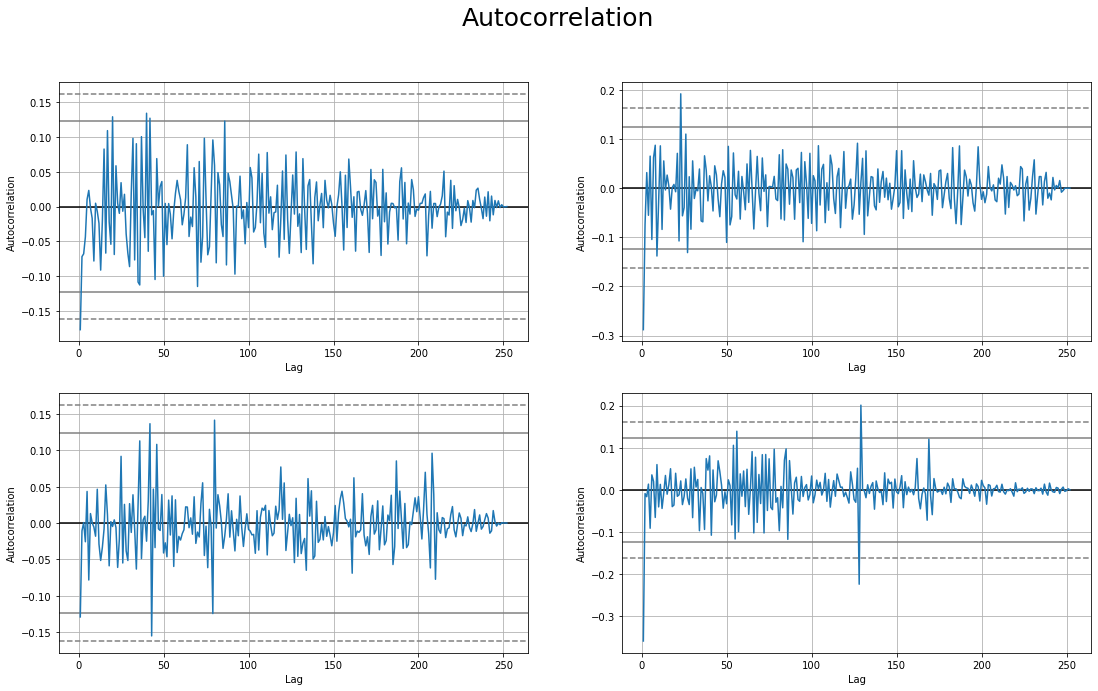

In [19]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.suptitle('Autocorrelation', fontsize=25)
fig.set_size_inches(18.5, 10.5)
plots = sorted([[row, col] for col in range(0, 2) for row in range(0, 2)])

for ticker, (row, col) in zip(tickers, plots):
    autocorrelation_plot(joint_data[ticker], ax=axs[row, col])

### apply ljung-box test

In [20]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

pvalues = []

for ticker in tickers:
    # fit ARMA model to data
    res = sm.tsa.ARMA(joint_data[ticker], (1,1)).fit(disp=-1)
    # perform Ljung-Box test on residuals with lag=5
    stat, pvalue = sm.stats.acorr_ljungbox(res.resid, lags=[5])
    pvalues.append(pvalue[0])
    

In [21]:
import plotly.express as px

alpha = 0.05

pvalues_fig = px.bar(x=['alpha', *tickers], 
                     y=[alpha, *pvalues],
                     color=[alpha, *pvalues],
                     color_continuous_scale=px.colors.diverging.RdYlGn[::-1],
                     height=400, title='Ljung-Box test p-values')

pvalues_fig.show()